In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm
import gc
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


# Task 1

# Preprocessing


In [3]:
#load dataset
df_tr = pd.read_csv('/content/drive/MyDrive/assignment_2/data_transaction.csv') 

In [4]:
df_id = pd.read_csv('/content/drive/MyDrive/assignment_2/data_identity.csv')

In [5]:
gc.collect()

114

In [6]:
# merge 2 datasets 
df = df_tr.set_index('TransactionID').join(df_id.set_index('TransactionID'))

In [7]:
count = 0
nan_arr = []
for i in df.columns:
    if df[i].isna().sum()>200000:
        count+=1
        nan_arr.append(i)

In [8]:
target = df["isFraud"]

In [9]:
nan_arr.append("TransactionDT")
nan_arr.append("isFraud")

In [10]:

# drop useless features
df = df.drop(nan_arr, axis = 1)
#Label encoding of all categorical features
for i in df.columns:
    if df[i].dtype == np.dtype(object):
        le = preprocessing.LabelEncoder()
        df[i] = le.fit_transform(df[i])
# scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = scaler.fit_transform(df)
stat_df = df

In [11]:
gc.collect()

50

In [12]:
# to tensor!
df = torch.torch.from_numpy(pd.DataFrame(df).values).to(torch.float32)
# mask data
Ind_df = torch.isnan(df)
# merge data and mask
data = torch.hstack([df,Ind_df])
# train_test_split in my interpretation :)
X_train = data[:int(len(data)*0.8)]
X_test = data[int(len(data)*0.8):]

In [13]:
y_train = target[:int(len(data)*0.8)]
y_test = target[int(len(data)*0.8):]

In [14]:
# dataloader for models
data_loader = DataLoader(torch.nan_to_num(X_train, nan=1.0), batch_size=300)
test_data_loader = DataLoader(torch.nan_to_num(X_test, nan=1.0), batch_size=300)

In [15]:
gc.collect()

200

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Autoenoders

# Undercomplete autoencoder

In [17]:
class autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, input_size//2),
            nn.ReLU(True),
            nn.Linear(input_size//2, input_size//3),
            nn.Linear(input_size//3, input_size//4),
            nn.Tanh(),
            nn.Linear(input_size//4, latent_dim)
          )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_size//4),
            nn.ReLU(True),
            nn.Linear(input_size//4, input_size//3),
            nn.Linear(input_size//3, input_size//2),
            nn.Tanh(),
            nn.Linear(input_size//2, input_size)
          )
        self.encoder.apply(self.__init_weights)
        self.decoder.apply(self.__init_weights)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
        
    
    def encode(self,input):
        return self.encoder(input)
    
    def __init_weights(self,m):
      #Init the weights (optional)
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [18]:
learning_rate = 0.001
num_epochs = 50
AE = autoencoder(398,50).to(device)
print(AE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adagrad(AE.parameters(),lr=learning_rate)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=398, out_features=199, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=199, out_features=132, bias=True)
    (3): Linear(in_features=132, out_features=99, bias=True)
    (4): Tanh()
    (5): Linear(in_features=99, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=99, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=99, out_features=132, bias=True)
    (3): Linear(in_features=132, out_features=199, bias=True)
    (4): Tanh()
    (5): Linear(in_features=199, out_features=398, bias=True)
  )
)


In [ ]:
temp_loss = 100000000
best_on_test_model = 0
best_epo_test = 0
ae_loss = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    test_loss = 0.0
    for X in data_loader:
        X = X[0].to(device)

        optimizer.zero_grad()
        # forward
        output = AE(X)
        loss = criterion(output, X)

        # backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    ae_loss.append(loss.item())
        
        
        #test
    for t in test_data_loader: 
        t = t[0].to(device)
        test_output = AE(t)
        test_loss = criterion(test_output, t)

        test_loss+= test_loss.item()
            
    if test_loss <= temp_loss:
        temp_loss = test_loss
        best_on_test_model = AE.state_dict()
        best_epo_test = epoch
        
    print('train loss:  epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    print('test loss:  epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, test_loss.item()))
    print()
print("loss on test: ",str(temp_loss))
print("best epoch on test: ",str(best_epo_test))
torch.save(best_on_test_model, "/content/drive/MyDrive/AE_model")

train loss:  epoch [1/50], loss:0.0336
test loss:  epoch [1/50], loss:0.4347

train loss:  epoch [2/50], loss:0.0242
test loss:  epoch [2/50], loss:0.4188

train loss:  epoch [3/50], loss:0.0199
test loss:  epoch [3/50], loss:0.4060

train loss:  epoch [4/50], loss:0.0170
test loss:  epoch [4/50], loss:0.3954

train loss:  epoch [5/50], loss:0.0148
test loss:  epoch [5/50], loss:0.3879

train loss:  epoch [6/50], loss:0.0132
test loss:  epoch [6/50], loss:0.3829

train loss:  epoch [7/50], loss:0.0120
test loss:  epoch [7/50], loss:0.3801

train loss:  epoch [8/50], loss:0.0111
test loss:  epoch [8/50], loss:0.3778

train loss:  epoch [9/50], loss:0.0104
test loss:  epoch [9/50], loss:0.3760

train loss:  epoch [10/50], loss:0.0098
test loss:  epoch [10/50], loss:0.3738

train loss:  epoch [11/50], loss:0.0094
test loss:  epoch [11/50], loss:0.3713

train loss:  epoch [12/50], loss:0.0090
test loss:  epoch [12/50], loss:0.3691

train loss:  epoch [13/50], loss:0.0088
test loss:  epoch 

autoencoders loss

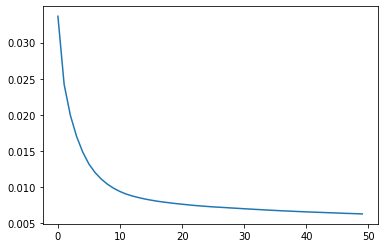

In [ ]:
import matplotlib.pyplot as plt
# plot loss
plt.plot(ae_loss)
plt.show()

Results of Autoencoder

In [21]:
# load my model from drive
AE.load_state_dict(torch.load("/content/drive/MyDrive/AE_model"))
AE.eval()
train_data = []
test_data = []
# creating dataset for classification
for i in data_loader:
  i = i.to(device)
  train_data.append(AE(i))
for i in test_data_loader:
  i = i.to(device)
  test_data.append(AE(i))

In [22]:
# tensors to numpy
X_train_AE = torch.cat(train_data).cpu().detach().numpy()
X_test_AE = torch.cat(test_data).cpu().detach().numpy()
gc.collect()

140

In [23]:
#finally , well known type and our dataset!!!
X_train_AE_df = pd.DataFrame(X_train_AE[:,:199])
X_test_AE_df = pd.DataFrame(X_test_AE[:,:199])

# X_train_AE_df.to_csv('/content/drive/MyDrive/assignment_2/X_train_AE_df.csv', index=False)
# X_test_AE_df.to_csv('/content/drive/MyDrive/assignment_2/X_test_AE_df.csv', index=False)

Classification on autoencoders dataset

In [24]:
gc.collect()

299

In [36]:
# RandomForest model
clf_ae = RandomForestClassifier(max_depth=15, n_jobs=-1)
clf_ae.fit(X_train_AE_df , y_train)
y_pred = clf_ae.predict(X_test_AE_df)

In [37]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    114044
           1       0.77      0.14      0.24      4064

    accuracy                           0.97    118108
   macro avg       0.87      0.57      0.61    118108
weighted avg       0.96      0.97      0.96    118108



In [38]:
gc.collect()

142

# Classification on statistical imputing aproach dataset

In [ ]:
# # creating dataset
# stat_df = pd.concat([Fraud_df,Not_fraud_df],axis = 0)
# stat_df = stat_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# target = stat_df["isFraud"]

# stat_df = stat_df.drop(["TransactionID", "TransactionDT", "isFraud"], axis = 1)
# # LabelEncoding
# for i in stat_df.columns:
#     if stat_df[i].dtype == np.dtype(object):
#         le = preprocessing.LabelEncoder()
#         stat_df[i] = le.fit_transform(stat_df[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
# nan imputing by puting column mean instead
stat_df = pd.DataFrame(stat_df).apply(lambda x: x.fillna(x.mean()),axis=0)

In [40]:
gc.collect()

44

In [41]:
# train_test_split
X_train_stat = stat_df[:int(len(stat_df)*0.8)]
X_test_stat = stat_df[int(len(stat_df)*0.8):]
y_train_stat = target[:int(len(stat_df)*0.8)]
y_test_stat = target[int(len(stat_df)*0.8):]

In [42]:
# classification
clf_ae_stat = RandomForestClassifier(max_depth=15)
clf_ae_stat.fit(X_train_stat , y_train_stat)
y_pred = clf_ae_stat.predict(X_test_stat)

In [43]:
print(classification_report(y_test_stat,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    114044
           1       0.83      0.26      0.40      4064

    accuracy                           0.97    118108
   macro avg       0.90      0.63      0.69    118108
weighted avg       0.97      0.97      0.97    118108



# Regularized autoencoder

All further code almost same as in Undercomplete autoencoder part, so comments also same

In [17]:
class reg_autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(reg_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, input_size//2),
            nn.ReLU(True),
            nn.Linear(input_size//2, input_size//3),
            nn.Linear(input_size//3, input_size//4),
            nn.Tanh(),
            nn.Linear(input_size//4, latent_dim)
          )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_size//4),
            nn.ReLU(True),
            nn.Linear(input_size//4, input_size//3),
            nn.Linear(input_size//3, input_size//2),
            nn.Tanh(),
            nn.Linear(input_size//2, input_size)
          )
        self.encoder.apply(self.__init_weights)
        self.decoder.apply(self.__init_weights)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
        
    
    def encode(self,input):
        return self.encoder(input)
    
    def __init_weights(self,m):
      #Init the weights (optional)
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [18]:
learning_rate = 0.001
num_epochs = 20
reg_AE = reg_autoencoder(398,50).to(device)
print(reg_AE)

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(reg_AE.parameters(),lr=learning_rate)

reg_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=398, out_features=199, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=199, out_features=132, bias=True)
    (3): Linear(in_features=132, out_features=99, bias=True)
    (4): Tanh()
    (5): Linear(in_features=99, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=99, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=99, out_features=132, bias=True)
    (3): Linear(in_features=132, out_features=199, bias=True)
    (4): Tanh()
    (5): Linear(in_features=199, out_features=398, bias=True)
  )
)


In [ ]:
temp_loss = 100000000
best_on_test_model = 0
best_epo_test = 0
rae_loss = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    test_loss = 0.0
    for X in data_loader:
        X = X[0].to(device)

        optimizer.zero_grad()
        # forward
        output = reg_AE(X)
        loss = criterion(output, X)

        regul = 0.0
        for param in reg_AE.parameters():
            regul += torch.abs((torch.norm(param, 1)))
        regul *= 0.00001

        loss += regul

        # backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    rae_loss.append(loss.item())        

        #test
    for t in test_data_loader: 
        t = t[0].to(device)
        test_output = reg_AE(t)
        test_loss = criterion(test_output, t)

        test_loss+= test_loss.item()
            
    if test_loss <= temp_loss:
        temp_loss = test_loss
        best_on_test_model = reg_AE.state_dict()
        best_epo_test = epoch
        
    print('train loss:  epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    print('test loss:  epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, test_loss.item()))
    print()
print("loss on test: ",str(temp_loss))
print("best epoch on test: ",str(best_epo_test))
torch.save(best_on_test_model, "/content/drive/MyDrive/RAE_model")

train loss:  epoch [1/20], loss:0.0868
test loss:  epoch [1/20], loss:0.3814

train loss:  epoch [2/20], loss:0.0739
test loss:  epoch [2/20], loss:0.3862

train loss:  epoch [3/20], loss:0.0612
test loss:  epoch [3/20], loss:0.3828

train loss:  epoch [4/20], loss:0.0540
test loss:  epoch [4/20], loss:0.3629

train loss:  epoch [5/20], loss:0.0511
test loss:  epoch [5/20], loss:0.3511

train loss:  epoch [6/20], loss:0.0470
test loss:  epoch [6/20], loss:0.3415

train loss:  epoch [7/20], loss:0.0441
test loss:  epoch [7/20], loss:0.3303

train loss:  epoch [8/20], loss:0.0429
test loss:  epoch [8/20], loss:0.3249

train loss:  epoch [9/20], loss:0.0406
test loss:  epoch [9/20], loss:0.3158

train loss:  epoch [10/20], loss:0.0408
test loss:  epoch [10/20], loss:0.3347

train loss:  epoch [11/20], loss:0.0396
test loss:  epoch [11/20], loss:0.3418

train loss:  epoch [12/20], loss:0.0385
test loss:  epoch [12/20], loss:0.3354

train loss:  epoch [13/20], loss:0.0386
test loss:  epoch 

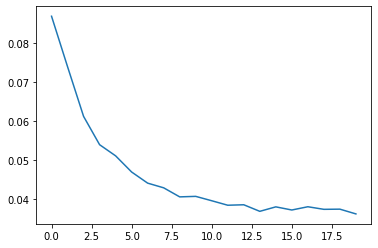

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rae_loss)
plt.show()

Classification on Reg Autoencoders dataset

In [19]:
reg_AE.load_state_dict(torch.load("/content/drive/MyDrive/RAE_model"))
reg_AE.eval()
train_data = []
test_data = []
for i in data_loader:
  i = i.to(device)
  train_data.append(reg_AE(i))
for i in test_data_loader:
  i = i.to(device)
  test_data.append(reg_AE(i))

In [20]:
X_train_RAE = torch.cat(train_data).cpu().detach().numpy()
X_test_RAE = torch.cat(test_data).cpu().detach().numpy()
gc.collect()

50

In [21]:
X_train_RAE_df = pd.DataFrame(X_train_RAE[:,:199])
X_test_RAE_df = pd.DataFrame(X_test_RAE[:,:199])

In [ ]:
# X_train_RAE_df.to_csv('/content/drive/MyDrive/assignment_2/X_train_RAE_df.csv', index=False)
# X_test_RAE_df.to_csv('/content/drive/MyDrive/assignment_2/X_test_RAE_df.csv', index=False)

In [23]:
from sklearn.ensemble import RandomForestClassifier
clf_rae = RandomForestClassifier(max_depth=15)
clf_rae.fit(X_train_RAE_df , y_train)
y_pred = clf_rae.predict(X_test_RAE_df) 

In [24]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    114044
           1       0.75      0.13      0.22      4064

    accuracy                           0.97    118108
   macro avg       0.86      0.56      0.60    118108
weighted avg       0.96      0.97      0.96    118108



# Variational autoencoder

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_size=398, h_dim=200, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, input_size//2)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x[0]*x[1])
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Start training
cri = nn.MSELoss()
vae_loss = []
num_epochs = 30
for epoch in range(num_epochs):
    for i, x in enumerate(data_loader):
        # Forward pass

        x1 = x[:,:199]
        mask = x[:,199:]
        rec, mu, log_var = model(x)
        
        reconst_loss = cri(rec*mask, x1)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 157 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    vae_loss.append(reconst_loss)

torch.save(model.state_dict(), "/content/drive/MyDrive/VAE_model")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch[1/30], Step [157/322], Reconst Loss: 0.6908, KL Div: 0.0018
Epoch[1/30], Step [314/322], Reconst Loss: 0.6765, KL Div: 0.0041
Epoch[2/30], Step [157/322], Reconst Loss: 0.6902, KL Div: 0.0006
Epoch[2/30], Step [314/322], Reconst Loss: 0.6763, KL Div: 0.0008
Epoch[3/30], Step [157/322], Reconst Loss: 0.6902, KL Div: 0.0004
Epoch[3/30], Step [314/322], Reconst Loss: 0.6763, KL Div: 0.0001
Epoch[4/30], Step [157/322], Reconst Loss: 0.6902, KL Div: 0.0000
Epoch[4/30], Step [314/322], Reconst Loss: 0.6763, KL Div: 0.0000
Epoch[5/30], Step [157/322], Reconst Loss: 0.6902, KL Div: 0.0000
Epoch[5/30], Step [314/322], Reconst Loss: 0.6763, KL Div: 0.0000
Epoch[6/30], Step [157/322], Reconst Loss: 0.6902, KL Div: -0.0000
Epoch[6/30], Step [314/322], Reconst Loss: 0.6763, KL Div: -0.0000
Epoch[7/30], Step [157/322], Reconst Loss: 0.6902, KL Div: 0.0000
Epoch[7/30], Step [314/322], Reconst Loss: 0.6763, KL Div: -0.0000
Epoch[8/30], Step [157/322], Reconst Loss: 0.6902, KL Div: -0.0000
Epoch[

In [ ]:
plt_arr = []
for i in vae_loss:
  plt_arr.append(i.detach().numpy())

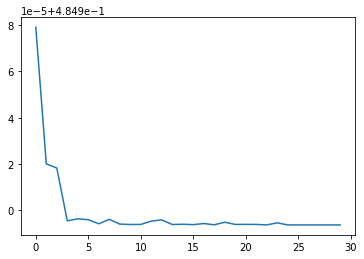

In [ ]:
import matplotlib.pyplot as plt

plt.plot(plt_arr)
plt.show()

Classification on VAE dataset

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/VAE_model"))
model.eval()
train_data = []
test_data = []
for i in data_loader:
  X ,  _, _ = model(i)
  train_data.append(X)
for i in test_data_loader:
  X ,  _, _ = model(i)
  test_data.append(X)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
X_train_VAE = torch.cat(train_data).detach().numpy()
X_test_VAE = torch.cat(test_data).detach().numpy()
gc.collect()

4721

In [ ]:
X_train_VAE_df = pd.DataFrame(X_train_VAE)
X_test_VAE_df = pd.DataFrame(X_test_VAE)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_rae = RandomForestClassifier(max_depth=3)
clf_rae.fit(X_train_RAE_df , y_train)
y_pred = clf_rae.predict(X_test_RAE_df)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91     20060
           1       0.62      0.13      0.22      4073

    accuracy                           0.84     24133
   macro avg       0.73      0.56      0.56     24133
weighted avg       0.81      0.84      0.79     24133



# Reduce the dimenssion of the data using Principal component analysis and Linear Discriminant Analysis and compare the impact on selected machine learning model

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Undercomplete autoencoder PCA and LDA

In [22]:
X_train_AE_df = pd.read_csv("/content/drive/MyDrive/assignment_2/X_train_AE_df.csv")
X_test_AE_df = pd.read_csv("/content/drive/MyDrive/assignment_2/X_test_AE_df.csv")

PCA

In [23]:
n_comp_arr = [5, 10, 15, 20]
best = 0
n_comp = 0
for i in n_comp_arr:
  pca = PCA(n_components = i)
  pca.fit(X_train_AE_df)
  print("n_components: ", str(i), " explained_variance: ", str(pca.explained_variance_ratio_.sum()))

n_components:  5  explained_variance:  0.7617546179533858
n_components:  10  explained_variance:  0.9264542857187726
n_components:  15  explained_variance:  0.977183712905475
n_components:  20  explained_variance:  0.9905181943403178


In [24]:
# PCA
pca = PCA(n_components = 20)
pca_AE_train_df = pca.fit_transform(X_train_AE_df)
pca_AE_test_df = pca.transform(X_test_AE_df)

clf_AE = RandomForestClassifier(max_depth = 15)
clf_AE.fit(pca_AE_train_df, y_train)

y_pred = clf_AE.predict(pca_AE_test_df)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    114044
           1       0.78      0.13      0.22      4064

    accuracy                           0.97    118108
   macro avg       0.87      0.56      0.60    118108
weighted avg       0.96      0.97      0.96    118108



LDA

In [25]:
gc.collect()

338

In [26]:
# LDA
lda = LinearDiscriminantAnalysis(n_components=1)
lda_AE_train_df = lda.fit_transform(X_train_AE_df, y_train)
lda_AE_test_df = lda.transform(X_test_AE_df)

clf_AE = RandomForestClassifier(max_depth = 15)
clf_AE.fit(lda_AE_train_df, y_train)

y_pred = clf_AE.predict(lda_AE_test_df)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    114044
           1       0.64      0.11      0.19      4064

    accuracy                           0.97    118108
   macro avg       0.81      0.56      0.59    118108
weighted avg       0.96      0.97      0.96    118108



# Task 2

# Preprocessing

In [69]:
train_df = pd.read_csv('/content/drive/MyDrive/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('/content/drive/MyDrive/UNSW_NB15_testing-set.csv')

Label encoder

In [70]:
# Label encoder from scratch :)
for i in train_df.columns:
    if train_df[i].dtype == np.dtype(object):
        unique_vals = list(set(list(train_df[i].unique()) +  list(test_df[i].unique())))
        numbers_list = []
        for j in range(len(unique_vals)):
          numbers_list.append(j)
        dictionary = dict(zip(unique_vals, numbers_list))

        train_df[i] = train_df[i].apply(lambda x: dictionary[x])
        test_df[i] = test_df[i].apply(lambda x: dictionary[x])

target data

In [71]:
y_train = train_df["label"]
y_test = test_df["label"]

In [72]:
# remove label features from train and test datasets
train_df = train_df.drop(["label"],axis = 1)
test_df = test_df.drop(["label"],axis = 1)

feature engineering

In [88]:
features_rem = []
for i in train_df.columns:
  # if 95 percent of the numbers from the feature are the same, then delete  
  if max(train_df[i].value_counts(normalize=True)) > 0.95:
    features_rem.append(i)

removing unbalansed features 

In [90]:
train_df = train_df.drop(features_rem, axis = 1)
test_df = test_df.drop(features_rem , axis = 1)

In [91]:
train_df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,attack_cat
0,1,0.000011,33,1,0,2,0,496,0,90909.090200,...,2,2,1,1,1,2,0,1,2,4
1,2,0.000008,33,1,0,2,0,1762,0,125000.000300,...,2,2,1,1,1,2,0,1,2,4
2,3,0.000005,33,1,0,2,0,1068,0,200000.005100,...,3,2,1,1,1,3,0,1,3,4
3,4,0.000006,33,1,0,2,0,900,0,166666.660800,...,3,2,2,2,1,3,0,2,3,4
4,5,0.000010,33,1,0,2,0,2126,0,100000.002500,...,3,2,2,2,1,3,0,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,33,1,0,2,0,104,0,200000.005100,...,1,2,2,1,1,2,0,2,1,4
82328,82329,1.106101,37,1,2,20,8,18062,354,24.410067,...,1,1,2,1,1,1,0,3,2,4
82329,82330,0.000000,97,1,0,1,0,46,0,0.000000,...,1,2,1,1,1,1,0,1,1,4
82330,82331,0.000000,97,1,0,1,0,46,0,0.000000,...,1,2,1,1,1,1,0,1,1,4


Data transformation (Rubust)

In [92]:
from sklearn.preprocessing import RobustScaler

In [93]:
transformer = RobustScaler()
train_df = transformer.fit_transform(train_df)
test_df = transformer.transform(test_df)

In [94]:
train_df

array([[-1.        , -0.0196385 , -1.        , ..., -0.33333333,
        -0.33333333,  0.        ],
       [-0.99997571, -0.01964267, -1.        , ..., -0.33333333,
        -0.33333333,  0.        ],
       [-0.99995142, -0.01964684, -1.        , ..., -0.33333333,
        -0.22222222,  0.        ],
       ...,
       [ 0.99995142, -0.01965379, 15.        , ..., -0.33333333,
        -0.44444444,  0.        ],
       [ 0.99997571, -0.01965379, 15.        , ..., -0.33333333,
        -0.44444444,  0.        ],
       [ 1.        , -0.01964128, -1.        , ..., -0.33333333,
        -0.44444444,  0.        ]])

# References

https://stackoverflow.com/a/209854